In [177]:
# !pip install qiskit
# !pip install qiskit-nature
# !pip install qiskit-visualization
# !pip install qiskit[visualization]
# !pip install qiskit-ibm-runtime
# !pip install qiskit-nature-pyscf
# !pip install qiskit-algorithms

In [178]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [179]:
# create a variable hamiltonian
hamiltonian_2 = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

# Hamiltonian for 4 qubits

hamiltonian_4 = SparsePauliOp.from_list([
    ('I'*4, 0.3980),
    ('Z'+'I'*3, -0.3980),
    ('ZZ'+'I'*2, -0.0113),
    ('XX'+'I'*2, 0.1810)
])

# Hamiltonian for 10 qubits
hamiltonian_10 = SparsePauliOp.from_list([
    ('I'*10, 0.3980),
    ('Z'+'I'*9, -0.3980),
    ('ZZ'+'I'*8, -0.0113),
    ('XX'+'I'*8, 0.1810)
])

# Hamiltonian for 20 qubits
hamiltonian_20 = SparsePauliOp.from_list([
    ('I'*20, 0.3980),
    ('Z'+'I'*19, -0.3980),
    ('ZZ'+'I'*18, -0.0113),
    ('XX'+'I'*18, 0.1810)
])

# Hamiltonian for 30 qubits
hamiltonian_30 = SparsePauliOp.from_list([
    ('I'*30, 0.3980),
    ('Z'+'I'*29, -0.3980),
    ('ZZ'+'I'*28, -0.0113),
    ('XX'+'I'*28, 0.1810)
])

# Hamiltonian for 50 qubits
hamiltonian_50 = SparsePauliOp.from_list([
    ('I'*50, 0.3980),
    ('Z'+'I'*49, -0.3980),
    ('ZZ'+'I'*48, -0.0113),
    ('XX'+'I'*48, 0.1810)
])





In [180]:


ansatz_2 = EfficientSU2(hamiltonian_2.num_qubits, insert_barriers = True)
ansatz_4 = EfficientSU2(hamiltonian_4.num_qubits, insert_barriers = True)
ansatz_10 = EfficientSU2(hamiltonian_10.num_qubits, insert_barriers = True)
ansatz_20 = EfficientSU2(hamiltonian_20.num_qubits, insert_barriers = True)
ansatz_30 = EfficientSU2(hamiltonian_30.num_qubits, insert_barriers = True)
ansatz_50 = EfficientSU2(hamiltonian_50.num_qubits, insert_barriers = True)


In [181]:
# prompt: num_params = ansatz.num_parameters for all the ansatz

num_params_2 = ansatz_2.num_parameters
num_params_4 = ansatz_4.num_parameters
num_params_10 = ansatz_10.num_parameters
num_params_20 = ansatz_20.num_parameters
num_params_30 = ansatz_30.num_parameters
num_params_50 = ansatz_50.num_parameters


In [182]:
# from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
# backend = FakeSherbrooke()

In [183]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token = '6242e54049d2ff9d25f377e77cadb313c90218d089a371bf06952cf4b9ec5cddddbf79a319ced5e00d1256042933b52ca66083afb47919d96cb5b58e47ef7a9a')



In [184]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [185]:
backend = service.backend('ibm_kyoto')

In [186]:
# backend = service.least_busy(operational=True, simulator=False)
print(backend.name)
print(backend.configuration().processor_type)
print(backend.configuration().supported_instructions)

ibm_kyoto
{'family': 'Eagle', 'revision': 3}
['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


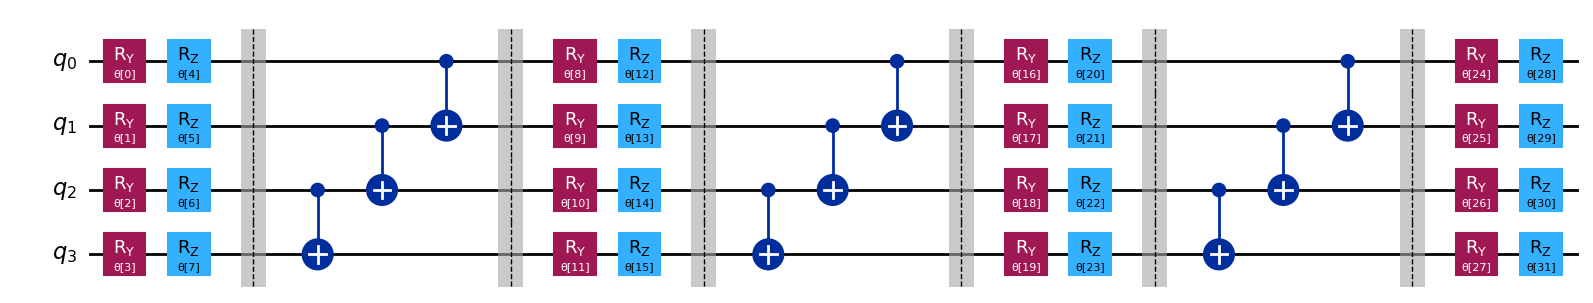

In [187]:
ansatz_4.decompose().draw("mpl", style="iqp")

In [188]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

optimization_level_answer = 2
pm = generate_preset_pass_manager(backend=backend,optimization_level=optimization_level_answer)

In [189]:
isa_circuit_2 = pm.run(ansatz_2)
isa_circuit_4 = pm.run(ansatz_4)
isa_circuit_10 = pm.run(ansatz_10)
isa_circuit_20 = pm.run(ansatz_20)
isa_circuit_30 = pm.run(ansatz_30)
isa_circuit_50 = pm.run(ansatz_50)

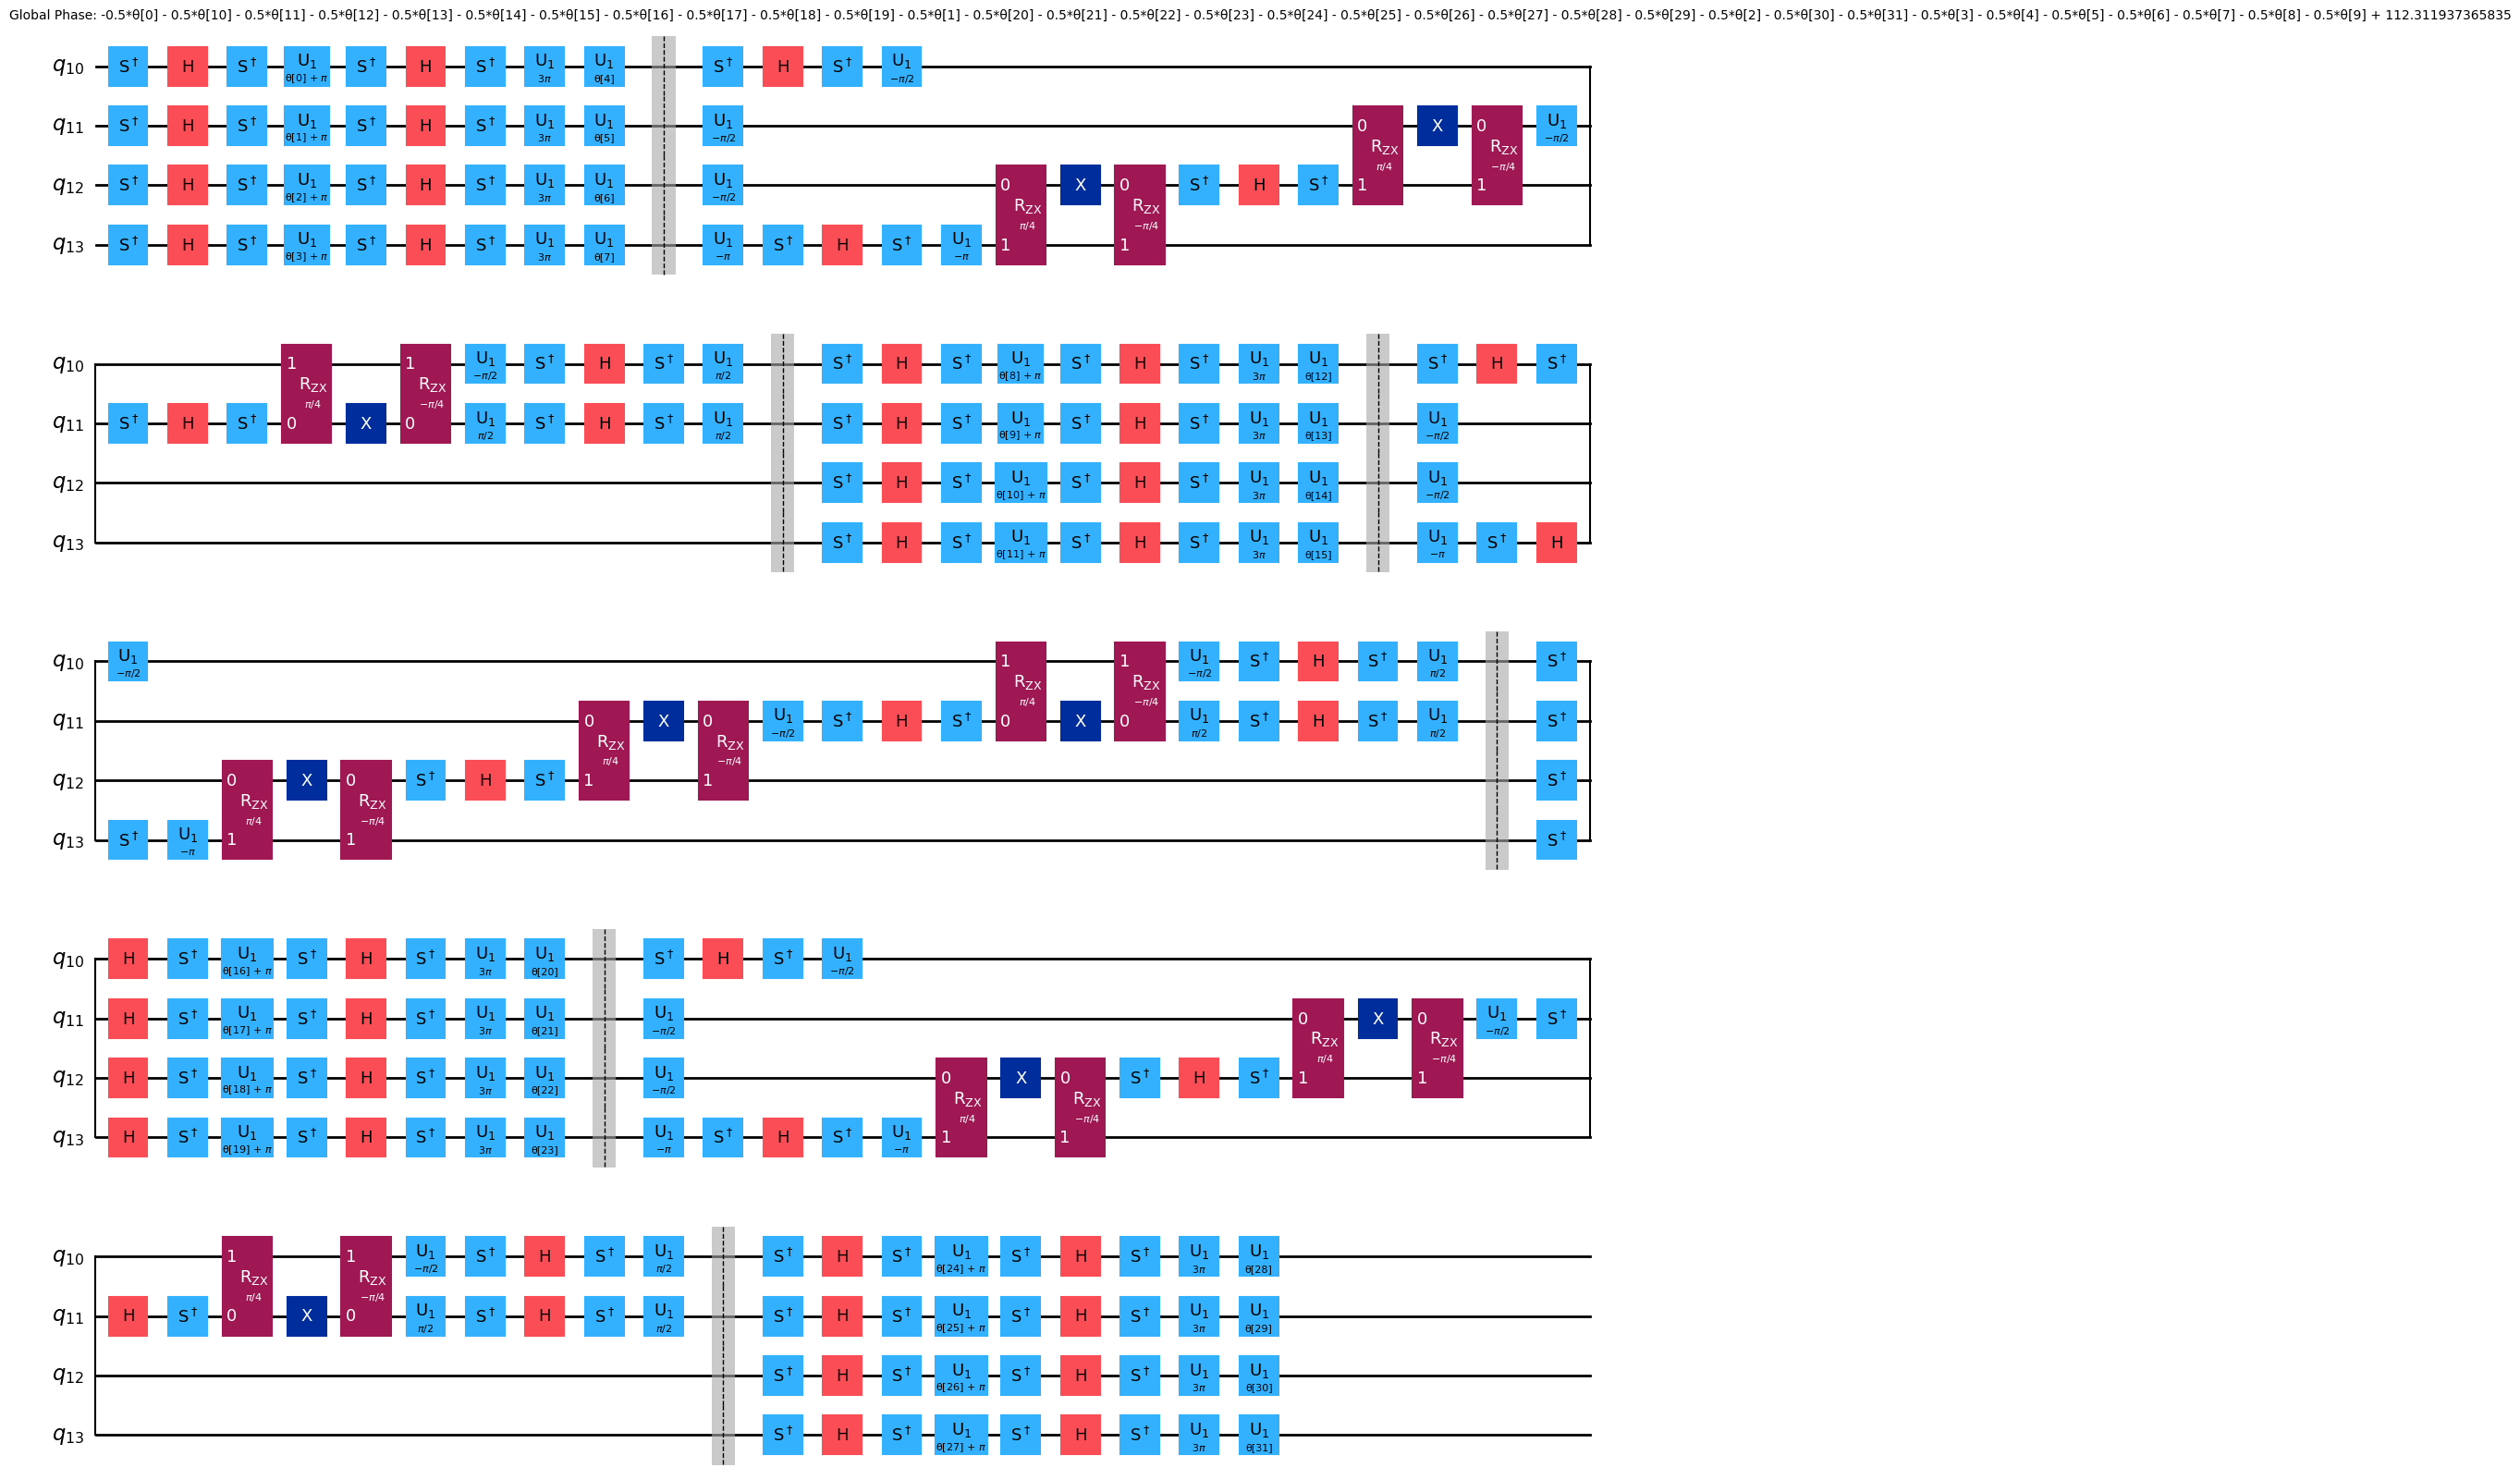

In [190]:
isa_circuit_4.decompose().draw("mpl", idle_wires=False)

In [191]:
## note: check with different optimization level and count ops
## use different ansatz and try to look how ansatz circuit nad isa circuit
## also look how the entangle gate changes
## also check with other optimisor as well

In [192]:


hamiltonian_isa_2  = hamiltonian_2.apply_layout(layout=isa_circuit_2.layout)
hamiltonian_isa_4  = hamiltonian_4.apply_layout(layout=isa_circuit_4.layout)
hamiltonian_isa_10  = hamiltonian_10.apply_layout(layout=isa_circuit_10.layout)
hamiltonian_isa_20  = hamiltonian_20.apply_layout(layout=isa_circuit_20.layout)
hamiltonian_isa_30  = hamiltonian_30.apply_layout(layout=isa_circuit_30.layout)
hamiltonian_isa_50  = hamiltonian_50.apply_layout(layout=isa_circuit_50.layout)


In [193]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz,[hamiltonian],[params]) #(circuit, observables, parameter_values)
    result = estimator.run(pubs= [pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)


### Don't change any code past this line ###
    print(f'Iteration: {callback_dict["iters"]} energy : {energy} ; Result : {result} ')
    return energy, result

In [194]:
callback_dict_2 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

callback_dict_4 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
callback_dict_10 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
callback_dict_20 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
callback_dict_30 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
callback_dict_50 = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [195]:
x_2 = 2 * np.pi * np.random.random(num_params_2)
x_4 = 2 * np.pi * np.random.random(num_params_4)
x_10 = 2 * np.pi * np.random.random(num_params_10)
x_20 = 2 * np.pi * np.random.random(num_params_20)
x_30 = 2 * np.pi * np.random.random(num_params_30)
x_50 = 2 * np.pi * np.random.random(num_params_50)

In [196]:


# # backend = FakeSherbrooke()
# # backend = AerSimulator()


def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy



In [176]:
# with Session(backend=backend) as session:
#     estimator = Estimator(session=session)
#     # estimator.options.default_shots = 1000
    

#     res = minimize(
#         cost_func_2,
#         x_2,
#         args=(isa_circuit_2, hamiltonian_isa_2, estimator, callback_dict_2),
#         method="cobyla",
#         options={'maxiter': 100})

Iteration: 1 energy : -0.08942915927419354 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[-0.08942916], stds=[0.00967854], ensemble_standard_error=[0.00872614]), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 
Iteration: 2 energy : -0.14884502752293582 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[-0.14884503], stds=[0.00735706], ensemble_standard_error=[0.0079225]), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resil

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [151]:
#dome
# with Session(backend=backend) as session:
#     estimator = Estimator(session=session)
#     estimator.options.default_shots = 1000
    
#     res_4 = minimize(
#         cost_func_2,
#         x_4,
#         args=(isa_circuit_4, hamiltonian_isa_4, estimator, callback_dict_4),
#         method="cobyla",
#         options={'maxiter': 100})

In [152]:
# currently running in my mlapton circuit_10

In [153]:


# with Session(backend=backend) as session:
#     estimator = Estimator(session=session)
#     estimator.options.default_shots = 1000
    
#     res_10 = minimize(
#         cost_func_2,
#         x_10,
#         args=(isa_circuit_10, hamiltonian_isa_10, estimator, callback_dict_10),
#         method="cobyla",
#         options={'maxiter': 100})


In [125]:
# circuit with 20 qubits

In [69]:

# with Session(backend=backend) as session:
#     estimator = Estimator(session=session)
#     estimator.options.default_shots = 1000
    
#     res_20 = minimize(
#         cost_func_2,
#         x_20,
#         args=(isa_circuit_20, hamiltonian_isa_20, estimator, callback_dict_20),
#         method="cobyla",
#         options={'maxiter': 100})

Iteration: 1 energy : 0.3632653990103238 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.3632654], stds=[0.01207316], ensemble_standard_error=[0.01420402]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 
Iteration: 2 energy : 0.37404825051548346 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.37404825], stds=[0.01672669], ensemble_standard_error=[0.01424007]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_meta

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [70]:
# callback_dict_20

{'prev_vector': array([2.81303863e+00, 3.40920032e+00, 3.22488410e+00, 1.03312852e+00,
        3.75638278e+00, 3.92991657e+00, 5.76823389e+00, 5.69247794e+00,
        5.95814591e+00, 2.83682001e+00, 5.51702306e+00, 5.34440955e+00,
        7.33277651e-01, 3.04217949e+00, 4.74247230e+00, 1.90386912e-01,
        1.29426354e+00, 4.14658160e+00, 5.95644750e-01, 1.50603601e-01,
        5.27823689e+00, 2.97679263e+00, 6.66381546e-01, 1.37166996e+00,
        2.45992101e+00, 6.09347564e+00, 2.05489787e+00, 4.77387937e+00,
        2.79705626e+00, 3.07558251e+00, 5.26667915e+00, 2.82185845e-02,
        5.84164622e+00, 1.12047794e+00, 6.11143252e+00, 3.90984292e-02,
        3.44619601e+00, 4.73026079e+00, 5.28814207e+00, 4.89769687e+00,
        5.30034715e-01, 3.52518014e+00, 2.44834688e+00, 5.48068491e+00,
        5.50545040e+00, 5.84184124e+00, 2.11142839e+00, 3.33755142e+00,
        4.44395524e+00, 3.56907276e+00, 5.20124873e+00, 4.03344794e+00,
        8.76658810e-01, 2.87292153e+00, 1.4706998

In [197]:


with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 1000
    
    res_30 = minimize(
        cost_func_2,
        x_30,
        args=(isa_circuit_30, hamiltonian_isa_30, estimator, callback_dict_30),
        method="cobyla",
        options={'maxiter': 100})

Iteration: 1 energy : 0.43213676370142134 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.43213676], stds=[0.0118798], ensemble_standard_error=[0.0138821]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 
Iteration: 2 energy : 0.43608792666183976 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.43608793], stds=[0.00904646], ensemble_standard_error=[0.01382747]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_meta

E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 50 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 21 energy : 0.42491060028660066 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.4249106], stds=[0.01849415], ensemble_standard_error=[0.01383622]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 43 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 22 energy : 0.43721618637201837 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.43721619], stds=[0.01223091], ensemble_standard_error=[0.01384423]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 36 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 23 energy : 0.44130967438577656 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.44130967], stds=[0.01293286], ensemble_standard_error=[0.01382943]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 30 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 24 energy : 0.4493396701531712 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.44933967], stds=[0.01318355], ensemble_standard_error=[0.01370138]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 24 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 25 energy : 0.41710769230769235 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.41710769], stds=[0.01227229], ensemble_standard_error=[0.01384471]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 18 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 26 energy : 0.4569807659876626 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.45698077], stds=[0.01260562], ensemble_standard_error=[0.01374281]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 12 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 27 energy : 0.4201510542813075 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.42015105], stds=[0.01330043], ensemble_standard_error=[0.01388157]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


E:\program_files\anaconda3\envs\IBM_C\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 51.5832548536879 quantum seconds, but you only have 6 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


Iteration: 28 energy : 0.43727872806324114 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.43727873], stds=[0.0146665], ensemble_standard_error=[0.01382437]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 


IBMRuntimeError: 'Failed to run program: \'403 Client Error: Forbidden for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"message":"Job create exceeds open plan job usage limits","code":4317,"solution":"Please wait until the beginning of next month to submit more jobs when your quota will reset.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [154]:


# with Session(backend=backend) as session:
#     estimator = Estimator(session=session)
#     estimator.options.default_shots = 1000
    
#     res_50 = minimize(
#         cost_func_2,
#         x_50,
#         args=(isa_circuit_50, hamiltonian_isa_50, estimator, callback_dict_50),
#         method="cobyla",
#         options={'maxiter': 100})


Iteration: 1 energy : 0.3213856738041504 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.32138567], stds=[0.01349992], ensemble_standard_error=[0.01421368]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 16})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}) 
Iteration: 2 energy : 0.3563339590100163 ; Result : PrimitiveResult([PubResult(data=DataBin<1>(evs=[0.35633396], stds=[0.01703535], ensemble_standard_error=[0.01428814]), metadata={'shots': 1024, 'target_precision': 0.03162277660168379, 'circuit_meta

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''